<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/colaborative-filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"f045f4a4adb9707f5c86d18bc28608b2"}'}

In [16]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar  9 01:20 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          13794  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          40593  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25           9851  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           2424  
karangadiya/fifa19                                        

In [20]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

 94% 215M/228M [00:02<00:00, 89.7MB/s]
100% 228M/228M [00:02<00:00, 96.8MB/s]
 54% 5.00M/9.30M [00:00<00:00, 41.5MB/s]
100% 9.30M/9.30M [00:00<00:00, 55.9MB/s]


In [21]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
  inflating: ratings.csv             
  inflating: ratings_small.csv       
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: keywords.csv            
  inflating: movies_metadata.csv     
  inflating: credits.csv             


In [22]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

In [24]:
!sudo pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 7.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
def load_tmdb_movies(path):
  df = pd.read_csv(path)
  df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
  json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
  for column in json_columns:
    df[column] = df[column].apply(json.loads)
  return df
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
def safe_access(container, index_values):
  result  = container
  try:
    for idx in index_values:
      result = result[idx]
    return result
  except IndexError or KeyError:
    return pd.np.nan
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
def pipe_flatten_names(keywords):
  return "|".join(x['name'] for x in keywords)

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

def convert_to_original_format(movies, credits):
  tmdb_movies = movies.copy()
  tmdb_movies.rename(columns= TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace = True)
  tmdb_movies['title_years']= pd.to_datetime(tmdb_movies['release_date']).apply(lambda x:x.year)
  tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
  tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x,[0,'name']))
  
  tmdb_movies['director_name'] = credits['crew'].apply(get_director)
  tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
  tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
  tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
  tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
  tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
  return tmdb_movies

In [26]:
convert_to_original_format(load_tmdb_movies('tmdb_5000_movies.csv'),load_tmdb_credits('tmdb_5000_credits.csv'))


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,The battle within.,Spider-Man 3,5.9,3576,2007.0,United States of America,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,They're taking adventure to new lengths.,Tangled,7.4,3330,2010.0,United States of America,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,Dav

In [27]:
!pip install fuzzywuzzy

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Shape: (4803, 26)


In [29]:
tab_info

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [0]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): 
      # neu liste
      continue 
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

def count_word(df, ref_col, liste):
  keyword_count = dict()
  for s in liste:
    keyword_count[s] = 0
  for liste_keywords in df[ref_col].str.split("|"):
    if type(liste_keywords) == float and pd.isnull(liste_keywords):
      continue
    for s in [s for s in liste_keywords if s in liste]: 
      if pd.notnull(s): 
        keyword_count[s] += 1
  keyword_occurences = []
  for k,v in keyword_count.items():
    keyword_occurences.append([k,v])
  keyword_occurences.sort(key = lambda x:x[1], reverse = True)
  return keyword_occurences, keyword_count
        

In [31]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

In [32]:
missing_df = df_initial.isnull().sum(axis = 0 ).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['filling_factor'] = (df_initial.shape[0]- missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [33]:
df_initial['decade'] = df_initial['title_years'].apply(lambda x:((x-1900)//10)*10)
def get_stats(gr):
  return {
      'min':gr.min(),
      'max':gr.max(),
      'count':gr.count(),
      'mean':gr.mean()
  }
test = df_initial['title_years'].groupby(df_initial['decade']).apply(get_stats).unstack()
# phuong thuc groubpy dua tren gia tri va apply 1 phuong thuc va thong ke no bang unstack
# vi du groubpy(ten nha) dua tren phuong thuc sap xep 
pd.DataFrame(test)
                                         

,count,max,mean,min
decade,,,,
10.0,1.0,1916.0,1916.000000,1916.0
20.0,4.0,1929.0,1927.500000,1925.0
30.0,15.0,1939.0,1935.733333,1930.0
40.0,25.0,1949.0,1944.560000,1940.0
50.0,27.0,1959.0,1954.296296,1950.0
60.0,71.0,1969.0,1965.028169,1960.0
70.0,109.0,1979.0,1974.944954,1970.0
80.0,278.0,1989.0,1984.715827,1980.0
90.0,778.0,1999.0,1996.141388,1990.0


In [34]:
test.describe()

,count,max,mean,min
count,11.000000,11.000000,11.000000,11.000000
mean,436.545455,1968.545455,1965.134468,1961.000000
std,699.286403,33.332758,32.432070,31.701735
min,1.000000,1916.000000,1916.000000,1916.000000
25%,20.000000,1944.000000,1940.146667,1935.000000
50%,71.000000,1969.000000,1965.028169,1960.000000
75%,528.000000,1994.000000,1990.428608,1985.000000
max,2048.000000,2017.000000,2012.762794,2010.000000


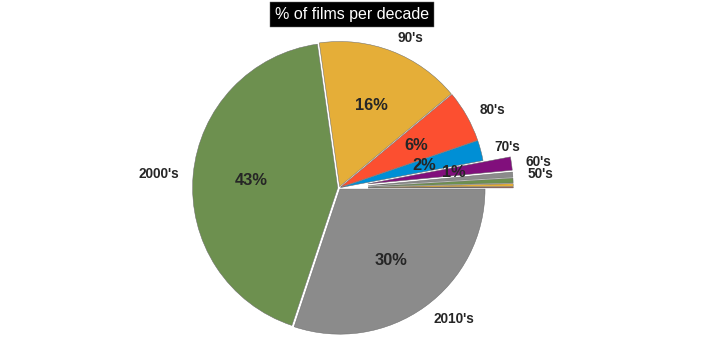

In [35]:
sns.set_context("poster", font_scale=0.85)
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

In [0]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
  genre_labels = genre_labels.union(set(s))

In [37]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [38]:
df_initial['genres'].unique()

array(['Action|Adventure|Fantasy|Science Fiction',
       'Adventure|Fantasy|Action', 'Action|Adventure|Crime', ...,
       'Thriller|Horror|Comedy', 'Foreign|Thriller',
       'Comedy|Drama|Romance|TV Movie'], dtype=object)

In [0]:
df_duplicate_cleaned = df_initial


In [0]:
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [41]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'plot_keywords')


Nb of keywords in variable 'plot_keywords': 9474


In [42]:
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alien', 'alienation'} 2
2 {'spying', 'spy'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terrorism', 'terror'} 2
5 {'flooding', 'flood'} 2
6 {'spiders', 'spider'} 2
7 {'horse', 'horses'} 2
8 {'musical', 'music'} 2
9 {'animal', 'animation', 'anime'} 3
10 {'compass', 'compassion'} 2
11 {'train', 'training'} 2
12 {'sail', 'sailing'} 2
13 {'time travel', 'time traveler'} 2
14 {'orcs', 'orc'} 2


In [0]:
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [0]:
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)


In [45]:
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [46]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            #_______________________________
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [48]:
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "extraterrestrial              " in keywords list -> True 4
 "alien                         " in keywords list -> True 80
 "noncitizen                    " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0
 "unknown                       " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "extraterrestrial being        " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0


In [0]:
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [50]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creation of a dictionary to replace keywords by higher frequency keywords
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals
    #_________________________________________________________________
    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue       # no replacement
    if mot == liste_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.95% of the keywords.


In [51]:
# 2 successive replacements
#---------------------------
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]  

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [52]:
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8911


In [53]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]


[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [0]:
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste))
    return df_new

In [55]:
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 2121


In [56]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]


[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

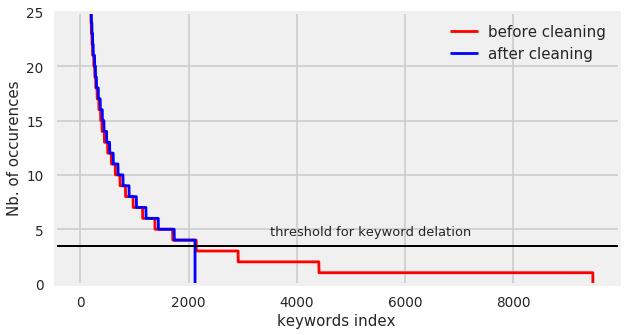

In [57]:
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()


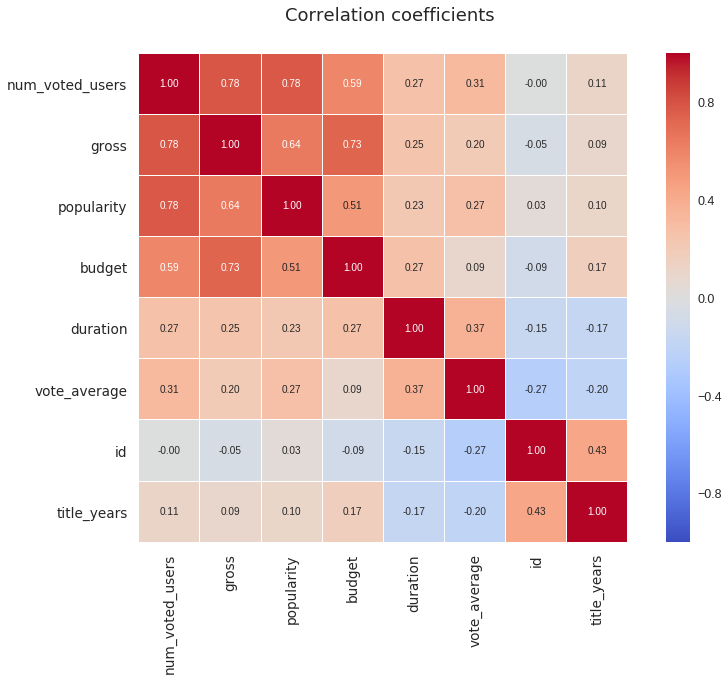

In [58]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

In [0]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

In [60]:
missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df


,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


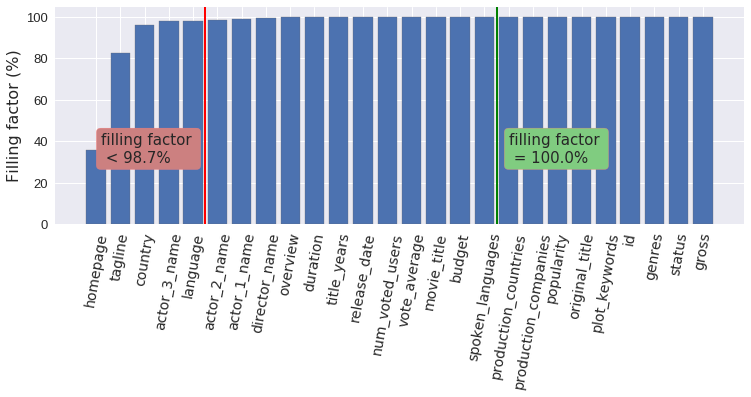

In [61]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 17
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);

In [62]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_years'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [0]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x - y)**2 / (2*sigma)**2)
def entry_variables(df, id_entry):
  col_labels = []
  if pd.notnull(df['director_name'].iloc[id_entry]):
    for s in df['director_name'].iloc[id_entry].split("|"):
      col_labels.append(s)
  for i in range(3):
    column =  'actor_NUM_name'.replace('NUM', str(i+1))
    if pd.notnull(df[column].iloc[id_entry]):
      for s in df[column].iloc[id_entry].split('|'):
        col_labels.append(s)
  if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
  return col_labels
  
def add_variables(df, REF_VAR):
  for s in REF_VAR:
    df[s] = pd.Series([0 for _ in range(len(df))])
  colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']  
  for categorie in colonnes:
    for index, row in df.iterrows():
      if pd.isnull(row[categorie]):
        continue
      for s in row[categorie].split('|'):
        if s in REF_VAR:
          df.set_value(index, s, 1)
  return df


In [0]:
def recommand(df, id_entry):
  df_copy = df.copy(deep = True)
  liste_genres = set()
  for s in df['genres'].str.split('|').values:
    liste_genres = liste_genres.union(set())
      # Create additional variables to check the similarity
  variables = entry_variables(df_copy, id_entry)
  variables+= list(liste_genres)
  df_new = add_variables(df_copy, variables)
      # determination of the closest neighbors: the distance is calculated / new variables
  X = df_new.as_matrix(variables)
  nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)

  distances, indices = nbrs.kneighbors(X)    
  xtest = df_new.iloc[id_entry].as_matrix(variables)
  xtest = xtest.reshape(1, -1)

  distances, indices = nbrs.kneighbors(xtest)

  return indices[0][:]
    